<H3> Init </H3>

In [1]:
%reload_ext autoreload
%autoreload 2
#ignore warnings.
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

<H3> Imports and Constants </H3>

In [2]:
#imports
import pandas as pd
import numpy as np
import os, sys, itertools as it, random
import datetime as dt
from datetime import datetime 
from sklearn.metrics import precision_score, accuracy_score, recall_score, balanced_accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, log_loss, roc_curve, brier_score_loss

#constants
mu = 0
sigma = 1

#path
sys.path.append('../modules')

<H3> File Configurations </H3>

In [3]:
def load_configurations():
    #configurations of prediction file [column header, format, range etc.]
    c_p={
            'dir': '../newdata/predictions/',
            'file': 'prediction_shift_0.csv',
            'number_of_samples': 500,
            'id_column': 'person_id',
            'id_format': int,
            'date_column': 'Date',
            'start_date': '2016-01-01',
            'end_date': '2018-01-01',
            'model_columns': ['lin_reg', 'rand_forest', 'xg_boost', 'sgmm'],
            'model_format': int
        }

    #configurations of referral file [column header, format, range etc.]
    c_r={
            'dir': '../newdata/referrals/',
            'file': 'referral.csv',
            'number_of_samples': 25,
            'start_date': '2016-01-01',
            'end_date': '2018-01-01',
            'id_column': 'person_id',
            'id_format': int,
            'date_column': 'Date',
            'day_to_evaluate': 1 #evaluate on day 1 of each month
        }
    
    #configurations for the experiment
    c_e={
            'experiment': 'Version 1.0',
            'dir': '../newdata/results',
            'file': 'results.csv',
            'thresholding': 0.5,
            'top_k': 50,
            'window': [[0,3], [0,6], [0,12]],
            'eval_method': 'top_k',
            'eval_date': pd.to_datetime(dt.date(2017,1,1))
        }
    
    return c_p, c_r, c_e

<H3> HELPER FUNCTIONS </H3>

In [4]:
#data = dataframe, file='/relative_path/to/file'
def dataframe_to_csv(data, file, append=True):
    if append and os.path.exists(file):
        with open(file, 'a') as f:
            data.to_csv(f, header=False, index = False)
    else:
        data.to_csv(file, index = False)

In [5]:
#generate random date between a range
#input in datetime.date format
def generate_random_date(start_date, end_date, iteration):
    date_list = []
    seed = 0
    for i in range(iteration):
        s_date = datetime.strptime(start_date, '%Y-%m-%d')
        e_date = datetime.strptime(end_date, '%Y-%m-%d')
        time_between_dates = e_date - s_date
        days_between_dates = time_between_dates.days
        random.seed(seed)
        random_number_of_days = random.randrange(days_between_dates)
        random_date = s_date + dt.timedelta(days=random_number_of_days)
        random_date = random_date.strftime('%Y-%m-%d')
        date_list.append(random_date)
        seed += 1
    
    return date_list
    

In [6]:
#preprocess referral dates
#convert any day in any month to the first day of that month in REFERRAL data
def convert_dates_ref(c_r):
    file_ref = c_r['dir'] + c_r['file']
    ref = pd.read_csv(file_ref)
    ref_date_column = ref[c_r['date_column']] 
    for i in range(len(ref_date_column)):
        formatted_date = datetime.strptime(ref_date_column[i], '%Y-%m-%d')
        new_formatted_date = datetime(formatted_date.year, formatted_date.month, c_r['day_to_evaluate']).strftime('%Y-%m-%d')
        ref.at[i,c_r['date_column']] = new_formatted_date
        
    return ref
        
    

In [7]:
#convert top k probability of a target to 1, O/W to 0 mapping
def prob_to_bin(target, k):
    ind=np.argpartition(target, -k)[-k:]
    target_bin=np.zeros(len(target))
    target_bin[ind]=1
    return target_bin

<H3> Generate Synthetic Data </H3>

In [8]:
def generate_synthetic_ground_truth_data(c_p, c_r):
    seed = 0
    np.random.seed(seed)
    patients = pd.Series([x for x in np.random.randint(0, c_p['number_of_samples'], c_r['number_of_samples'])])
    patients = patients.sort_values(ascending=True).reset_index(drop=True)
    date = pd.Series([d for d in generate_random_date(c_r['start_date'], c_r['end_date'], c_r['number_of_samples'])])
    data = pd.DataFrame({c_r['id_column']:patients, c_r['date_column']:date})
    dataframe_to_csv(data, c_r['dir']+c_r['file'], False)


In [9]:
def generate_synthetic_prediction_data(c_p):
    patients = pd.Series(range(0, c_p['number_of_samples'])) #500
    date = pd.date_range(c_p['start_date'], c_p['end_date'], freq='MS') #25
    data = pd.DataFrame(list(it.product(patients,date)),columns=[c_p['id_column'],c_p['date_column']])
    seed = 0
    for model in c_p['model_columns']:
        np.random.seed(seed)
        data[model] = pd.Series(np.random.random((data.shape[0])))
        seed+=1
    dataframe_to_csv(data, c_p['dir']+c_p['file'], False)

<H3> Score Class </H3>

In [23]:
class Score:
    
    def __init__(self, model_name):
        self.model_name = model_name
        self.precision = {}
        self.recall = {}
        self.accuracy = {}
        self.balanced_accuracy = {}
        self.f1_score = {}
        self.roc_auc_score = {} 
        self.log_loss = {}
        self.brier_score_loss = {}
    
    def get_precision(self, y_true, y_predict, average='binary'):
        return precision_score(y_true, y_predict, average)
    
    def get_recall(self, y_true, y_predict, average='binary'):
        return recall_score(y_true, y_predict, average)
    
    def get_accuracy(self, y_true, y_predict):
        return recall_score(y_true, y_predict)
    
    def get_balanced_accuracy(self, y_true, y_predict):
        return balanced_accuracy_score(y_true, y_predict)
    
    def get_f1_score(self, y_true, y_predict, average='binary'):
        return f1_score(y_true, y_predict, average='binary')
    
    def get_roc_auc_score(self, y_true, y_predict):
        return roc_auc_score(y_true, y_predict)
    
    def get_log_loss(self, y_true, y_predict):
        return log_loss(y_true, y_predict)
    #-----------------------------------------------------
    #need to implement
    #prob_from_a_model = [0.8, 0.3, 0.5]
    #ground_truth_binary = [1,0,0]
    #briar score(ground_truth_binary, prob_from_a_model)
    def get_brier_score_loss(self, y_true, y_predict):
        return brier_score_loss(y_true, y_predict)
    
        

<H3> Score Calculation </H3>

In [11]:
#pd.to_Datetime(anything) = create datetime object
#datetime.strptime(string) -> datetime object
#datetime.strftime(datetime) -> string in different formats

def evaluate(c_p, c_r, c_e, eval_method='top_k'):
    
    referral = convert_dates_ref(c_r)
    prediction = pd.read_csv(c_p['dir'] + c_p['file'])
    
    ref_copy = referral.copy()
    pred_copy = prediction.copy()
    
    ref_copy['target'] = pd.Series(np.ones(c_r['number_of_samples'], dtype=float))
    ref_copy[c_r['date_column']] = pd.to_datetime(ref_copy[c_r['date_column']])
    ref_copy = ref_copy.pivot_table(index=c_r['id_column'], columns=c_r['date_column'], values='target', aggfunc='sum')
    ref_copy = ref_copy.fillna(0)

    #ref_copy has (1,4,6,8,9,11,12 in 2017 months), don't worry
    #now both pred_copy['Date'] and ref_copy['Date'] is in Datetime format instead of previous String format
    
    pred_copy[c_p['date_column']] = pd.to_datetime(pred_copy[c_p['date_column']])
    pred_copy = pred_copy.loc[pred_copy[c_p['date_column']]==c_e['eval_date']]
    
    all_model_evaluations = {} #{'model_name':score class object for that model}
    
    #now branch out for each model
    for model in c_p['model_columns']:
        
        evaluated_model_obj = Score(model)
        
        #calculate for each window
        for window in c_e['window']:
            
            start = c_e['eval_date'] + pd.DateOffset(months=window[0])
            end = c_e['eval_date'] + pd.DateOffset(months=window[1])
            
            sl=slice(start,end)
            y_true = ref_copy.loc[:,sl]
            y_true = y_true.sum(axis=1)
            
            #for the time being, all ref patients are in pred_list. 
            #Change random.randint upper_range in data_generate to tweak
            y_true=y_true[y_true.index.isin(pred_copy[c_p['id_column']])]
            
            y_true=y_true.append(pd.Series(0,index=set(pred_copy[c_p['id_column']])-set(y_true.index))).sort_index()
        
            #their size have to be same -- TO USE the built in metric functions
            if pred_copy.shape[0]!=len(y_true):
                print("ERROR: PREDICTION AND ACTUAL DATAFRAME HAVE DIFFERENT NUMBERS.  PREDICTION:",pred_copy.shape[0], " EVALUATION: ",len(y_true))
                break
            
            #column label
            label = model+'_bin_'+str(window[1])+'_'+eval_method
            
            #now thresholding method
            if eval_method=='top_k':
                pred_copy[label] = prob_to_bin(pred_copy[model], c_e['top_k'])
    
            elif eval_method == 'thresholding':
                pred_copy[label] = np.where(pred_copy[model] > c_e['thresholding'], 1, 0)
            
            #model score for this window update
            update_model_score(model, evaluated_model_obj, label, y_true, pred_copy)
            
        all_model_evaluations.update({model:evaluated_model_obj})
    
    return all_model_evaluations
            

In [24]:
def update_model_score(model, evaluated_model_obj, label, y_true, pred_copy):
    
    precision = evaluated_model_obj.get_precision(y_true.values, pred_copy[label].values)
    evaluated_model_obj.precision.update({label:precision})

    recall = evaluated_model_obj.get_recall(y_true.values, pred_copy[label].values)
    evaluated_model_obj.recall.update({label:recall})

    accuracy = evaluated_model_obj.get_accuracy(y_true.values, pred_copy[label].values)
    evaluated_model_obj.accuracy.update({label:accuracy})

    balanced_accuracy = evaluated_model_obj.get_balanced_accuracy(y_true.values, pred_copy[label].values)
    evaluated_model_obj.balanced_accuracy.update({label:balanced_accuracy})

    f1_score = evaluated_model_obj.get_f1_score(y_true.values, pred_copy[label].values)
    evaluated_model_obj.f1_score.update({label:f1_score})

    #these will take predicted probabilites, not thresholded binaries

    log_loss = evaluated_model_obj.get_log_loss(y_true.values, pred_copy[model].values)
    evaluated_model_obj.log_loss.update({label:log_loss})

    roc_auc_score = evaluated_model_obj.get_roc_auc_score(y_true.values, pred_copy[model].values)
    evaluated_model_obj.roc_auc_score.update({label:roc_auc_score})
    
    brier_score_loss = evaluated_model_obj.get_brier_score_loss(y_true.values, pred_copy[model].values)
    evaluated_model_obj.brier_score_loss.update({label:brier_score_loss})
    
    

<H3> Visualization </H3>

In [25]:
def visualize_performance(model_name, model_score):
    #all dictionaries with different windows
    precision = model_score.precision
    recall = model_score.recall
    accuracy = model_score.accuracy
    balanced_accuracy = model_score.balanced_accuracy
    f1_score = model_score.f1_score
    log_loss = model_score.log_loss
    roc_auc_score = model_score.roc_auc_score
    brier_score_loss = model_score.brier_score_loss
    
    metric_name = ['precision', 'recall', 'accuracy', 'balanced_accuracy', 'f1_score', 'log_loss', 'roc_auc_score', 'brier_score_loss']
    metric_value = [precision, recall, accuracy, balanced_accuracy, f1_score, log_loss, roc_auc_score, brier_score_loss]
    
    data = pd.DataFrame(metric_value, index=metric_name)
    
    data.plot.bar()

<H2> MAIN </H2>

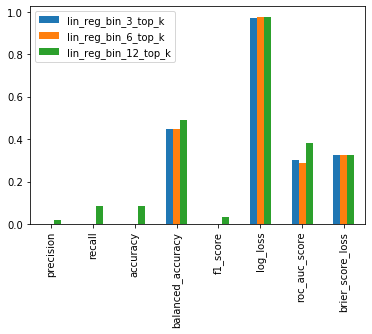

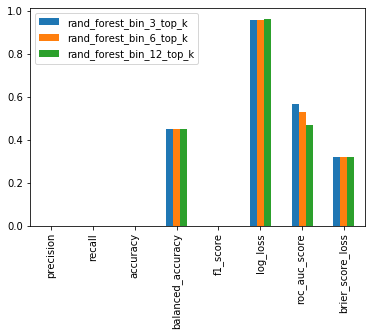

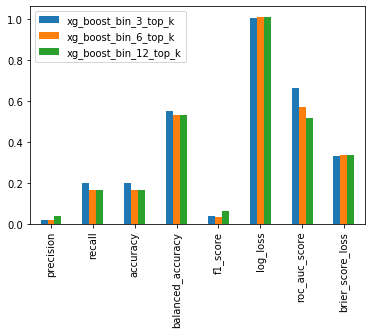

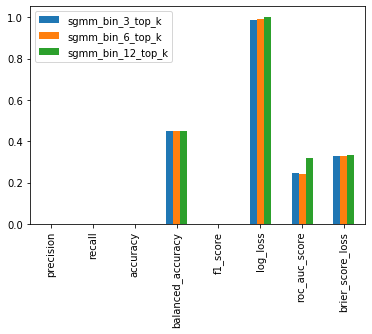

In [26]:
#pd.set_option('display.max_rows', None)
if __name__ == "__main__":
    c_p, c_r, c_e = load_configurations()
    generate_synthetic_ground_truth_data(c_p, c_r)
    generate_synthetic_prediction_data(c_p)
    all_model_evaluations = evaluate(c_p, c_r, c_e, 'top_k')
    for model_name in all_model_evaluations:
        visualize_performance(model_name, all_model_evaluations[model_name])
    